In [1]:
%env SKLEARN_SITE_JOBLIB=1
# https://github.com/scikit-learn/scikit-learn/issues/10533
# https://github.com/scikit-learn/scikit-learn/issues/12250
# %env LOKY_PICKLER='cloudpickle' 
# import multiprocessing
# multiprocessing.set_start_method('forkserver')
# import cloudpickle

env: SKLEARN_SITE_JOBLIB=1


In [2]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

new_filename = "final_project_dataset_PROVEN.pkl"
exec(open("poi_id.py").read())

# Udacity Final Project: Identify Fraud from Enron Email
From [Wikipedia:](https://en.wikipedia.org/wiki/Enron)
> Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. It was founded in 1985 as a merger between Houston Natural Gas and InterNorth, both relatively small regional companies. Before its bankruptcy on December 3, 2001, Enron employed approximately 29,000 staff and was a major electricity, natural gas, communications and pulp and paper company, with claimed revenues of nearly $101 billion during 2000.[1] Fortune named Enron "America's Most Innovative Company" for six consecutive years.

> At the end of 2001, it was revealed that Enron's reported financial condition was sustained by institutionalized, systematic, and creatively planned accounting fraud, known since as the Enron scandal. Enron has since become a well-known example of willful corporate fraud and corruption. The scandal also brought into question the accounting practices and activities of many corporations in the United States and was a factor in the enactment of the Sarbanes–Oxley Act of 2002. The scandal also affected the greater business world by causing the dissolution of the Arthur Andersen accounting firm, which had been Enron's main auditor for years.

The goal of this project is to create a model that is capable to classifiy if a person is likely a POI or not from data. The data to use is:
- A document of insider payments, such as salary and bonus
- Aggregated E-mail metadata, such as the number of E-Mails that were send to and recieved from a POI

From human observation and experience, there are probably some patterns and correlations in the data, that makes a person suspicious to be a POI, e.g.:
- high income
- high bonus (probably in relation to the regular salary)
- secured personal company stocks before the company went into bancrupcy because of insider knowledge
- high rate of E-Mail exchange with other POI's

In case such patterns exist, an appropriate machine learning algorithm would be able to learn them and perform predictions of wheather a person is likely a POI or not. One might argue, that e.g. the police or intelligence agencies could be interested in such methods to set priorities for investigations/tracings.

## Runing this Notebook, `poi_id.py` and `tester.py`
Scikit-learn support for Python 2.7 was discontinued since version 0.20, I decided do this project with state of the art technology and use the more recent standard version 3.6.5. A few changes to `poi_id.py` and `tester.py` were required for their usage in a Python 3 environment.

The most relevant packages were used in these versions:

In [427]:
import sklearn
import joblib
print("Python version: {0}".format(sys.version.split("(")[0] ))
print("scikit-learn:   {0}".format(sklearn.__version__))
print("joblib:         {0}".format(joblib.__version__))
print("pandas:         {0}".format(pd.__version__))
print("numpy:          {0}".format(np.__version__))

Python version: 3.6.5 
scikit-learn:   0.21.dev0
joblib:         0.13.0
pandas:         0.23.4
numpy:          1.15.4


## Overview of the Dataset and Removal of Outliers
The job of every good Data Analysts starts by understanding the task and the provided datasets.

In [3]:
print("Number of records: {}".format(len(data_dict_raw)))

Number of records: 146


In [3]:
print("Number of parameters: {}".format(len(df.columns)))

Number of parameters: 21


### List of parameters:

In [4]:
df.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees'],
      dtype='object')

The label `POI` indicates, if a person has been identified as a ***Person Of Interest***. The parameters/features provide financial data (e.g. salary, stock value, etc.) and E-mail communication metadata.

## Financial Data
The document `enron61702insiderpay.pdf` contains all the data and documentation.

![Enron Insider Pay](enron61702insiderpay_snap.png)

### Payments
1. `salary` Reflects items such as base salary, executive cash allowances, and benefits payments.
2. `bonus`Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.
3. `long_term_incentive` Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
4. `deferred_income` Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
5. `deferral payments` Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
6. `loan_advances` Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.
7. `other` Reflects items such as payments for severence, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
8. `expenses` Reflects reimbursements of business expenses. May include fees paid for consulting services.
9. `director_fees` Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

### Stock Value
10. `exercised_stock_options` Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities.
11. `restricted_stock` Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting
periods, regardless of whether deferred.
12. `restricted_stock_deferred` Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.


## E-mail data
Some metadata about the E-mail communication of these persons is provided too:

In [5]:
print(features_email_stats)

['from_messages', 'from_this_person_to_poi', 'to_messages', 'from_poi_to_this_person', 'shared_receipt_with_poi']


## Quality Check of the Provided Dataset
Regarding the financial data, the parameters `total_payments` and `total_stock_value` may serve as a kind of checksum, i.e. to ensure the integrity of the dataset.

Unfortunately, there are at least

In [6]:
def checksum_df(df, cols, expected_sum):
    """Returns all rows that do not match expected_sum"""
    df[expected_sum[0]] = df[expected_sum[0]].fillna(0.0)
    df_wrong_checksum = df[df[cols].sum(axis=1)!=df[expected_sum[0]]]
    df_wrong_checksum = df_wrong_checksum[cols+expected_sum]
    df_wrong_checksum = df_wrong_checksum[df_wrong_checksum.any(axis=1)]
    return df_wrong_checksum

df_salary_wrong_checksum = checksum_df(df, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum))

2


rows, where `total_payments` does not sum up to the expected value.

These are the rows:

In [7]:
HTML(df_salary_wrong_checksum.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BELFER ROBERT,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0


The same problem is present for the `total_stock_value`, for this number of rows:

In [8]:
df_stock_wrong_checksum = checksum_df(df, features_financial_stock, features_financial_stock_total)
print(len(df_stock_wrong_checksum))

2


This table is showing the corrupt rows:

In [9]:
HTML(df_stock_wrong_checksum.head(5).to_html())

,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
BELFER ROBERT,3285.0,NaN,44093.0,-44093.0
BHATNAGAR SANJAY,2604490.0,-2604490.0,15456290.0,0.0


Obviously, the quality of the provided data cannot be trusted. There may be two reasons for this:
1. The original data is already corrupt.
- The provided derived dataset `final_project_dataset.pkl` is corrupt due to human mistake.

In case of human mistake, it is possible to check the values in `enron61702insiderpay.pdf`.
Apparently, the original document has different values for the suspicious records. So there is at least a few obvious human errors.

However, there might be many more errors, although the checksum is correct.

## Correction of the provided input dataset
In order to correct human error in the process, it is neccessary to compare the dataset row by row.

### Parsing the full table from `enron61702insiderpay.pdf`
is required, since this is the original document.

In [10]:
import re
import numpy as np

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
has_numbers_re = re.compile(r'[0-9]+')

# INSIDERNAME_re = re.compile(r'(^[A-Z .]+, [A-Z]+ [A-Z])|(^[A-Z]+, [A-Z]+)')
INSIDERNAME_re = re.compile(r'(^[A-Z .]+, [A-Z]+ [A-Z .]+)|(^[A-Z-]+, [A-Z]+)')
FOOTNOTE_re = re.compile(r'^\([a-z]\)')
NUMBER_re = re.compile(r'(^\(\$([0-9,_]+)\))|(^\(([0-9,_]+)\))|(^\$[0-9,]+)|(^[0-9,]+)')
# SPACES_re = re.compile(r'[^\S\n\t]+') # https://stackoverflow.com/questions/38162444/python-regex-match-space-only
SPACES_re = re.compile(r'^\ ') # https://stackoverflow.com/questions/38162444/python-regex-match-space-only

tablestr = "ALLEN, PHILLIP K   $1233,43423  ($999,9) $324,001BADUM JR., JAMES P  25,234,000 (d) (21,123) 435,325,455BERBERIAN, DAVID 235,111"

def check_re(robj, s):
    m = robj.search(s)
    if m:
        name = m.group()
        return name
    else:
        return None

def parse_row(s):
    rowelements = []
    row_incomplete = True
    space = 0
    while row_incomplete:
        footnote = check_re(FOOTNOTE_re, s)
        number = check_re(NUMBER_re, s)        
        if not s:
            break
        if s[0] == ' ':
            s = s.split(' ', 1)[1]
            space += 1
        elif footnote:
            s = s.split(footnote, 1)[1]
        elif number:
            s = s.split(number, 1)[1]
            number = float(int(number.replace("$","").replace(",","").replace("(","").replace(")","")))
            rowelements.append(number)
            #print(space)
            space = 0
        elif s[0] == '-':
            s = s.split('-', 1)[1]
            rowelements.append(np.nan)
            #print(space)
            space = 0            
        else:
            row_incomplete = False
    new_s = s
    return new_s, rowelements

def parse_table(tablestr):
    d = {}
    table_incomplete = True
    while table_incomplete:
        n = check_re(INSIDERNAME_re, tablestr)
        if n:
            #print("name found: {}".format(n))
            tablestr = tablestr.split(n, 1)[1]
            tablestr, row = parse_row(tablestr)
            if row:
                n = n.replace(",","").replace(".","")
                d.update({n:row})
            else:
                table_incomplete = False
            #print(tablestr)
        else:
            table_incomplete = False
    return d

# For testing the functions
#dd = parse_table(tablestr)
#print(tablestr)
#print(dd)


In [11]:
# https://automatetheboringstuff.com/chapter13/
import PyPDF2

pdfReader = PyPDF2.PdfFileReader(open('enron61702insiderpay.pdf', 'rb'))
pages = [0,1,2,3]
data_dict = {}
for page in pages:
    print("Parsing page #{}...".format(page))
    pageObj = pdfReader.getPage(page)
    text = pageObj.extractText()
    table = text.split("Total Stock Value",1)[1]
    dd = parse_table(table)
    data_dict.update(dd)

Parsing page #0...
Parsing page #1...
Parsing page #2...
Parsing page #3...


In [12]:
cols = features_financial_salary + features_financial_salary_total + features_financial_stock + features_financial_stock_total
df_pdf = pd.DataFrame.from_dict(data_dict, columns=cols, orient='index')
# Deferral items are negative...
df_pdf['deferred_income'] = -df_pdf['deferred_income']
df_pdf['restricted_stock_deferred'] = -df_pdf['restricted_stock_deferred']
#df_pdf['deferral_payments'] = -df_pdf['deferral_payments']

In [13]:
df_salary_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum_pdf))

2


In [14]:
HTML(df_salary_wrong_checksum_pdf.to_html())


,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0
YEAP SOON,NaN,55097.0,NaN,-55097.0,192758.0,NaN,NaN,192758.0,NaN,0.0


In [15]:
print(df_salary_wrong_checksum_pdf.to_csv())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments
BHATNAGAR SANJAY,,,,,,,137864.0,,137864.0,15456290.0
YEAP SOON,,55097.0,,-55097.0,192758.0,,,192758.0,,0.0



The few suspicious rows are due to missing delimiters in the original document.

The values are corrected "by hand". The number of incorrect checksum is now for `features_financial_salary_total`:

In [16]:
ff = features_financial_salary+features_financial_salary_total + features_financial_stock + features_financial_stock_total

In [17]:
bs=[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,137864.0, np.nan,137864.0, 15456290.0, 2604490.0, -2604490.0, 15456290.0]
ys = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 55097.0, np.nan, 55097.0, 192758.0, np.nan, np.nan, 192758.0]
df_pdf.loc['BHATNAGAR SANJAY'] = pd.Series(bs, index=ff)
df_pdf.loc['poi', 'BHATNAGAR SANJAY'] = 0.0
df_pdf.loc['YEAP SOON'] = pd.Series(ys, index=ff)

After correcting the identifierd rows, the number of rows with wrong checksum should be "0":

In [18]:
df_salary_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_salary, features_financial_salary_total)
print(len(df_salary_wrong_checksum_pdf))

0


and for `features_financial_stock_total`:

In [19]:
df_stock_wrong_checksum_pdf = checksum_df(df_pdf, features_financial_stock, features_financial_stock_total)
print(len(df_stock_wrong_checksum_pdf))

0


Finally, the following table shows all the rows from the new self-parsed dataset that are different from the provided dataset. There are apparently 9 differences in a dataset of less than 150 records. However, a few are just the names that were parsed in a different way.

In [20]:
# https://stackoverflow.com/questions/19917545/comparing-two-pandas-dataframes-for-differences
def get_different_rows(source_df, new_df):
    """Returns just the rows from the new dataframe that differ from the source dataframe"""
    merged_df = source_df.merge(new_df, indicator=True, how='outer')
    changed_rows_df = merged_df[merged_df['_merge'] == 'right_only']
    return changed_rows_df.drop('_merge', axis=1)
#features_financial_salary+features_financial_salary_total #

df1 = df[ff].reset_index()
df2 = df_pdf[ff].reset_index()#.drop('index', axis=1)
df_diff12 = get_different_rows(df1, df2)
df_diff21 = get_different_rows(df2, df1)

HTML(df_diff12.to_html())

,index,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value
146,BAXTER JOHN C,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,NaN,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0
147,BELFER ROBERT A,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,0.0
148,BHATNAGAR SANJAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0
149,BLAKE JR NORMAN P,NaN,NaN,NaN,-113784.0,NaN,NaN,NaN,1279.0,113784.0,1279.0,NaN,NaN,NaN,0.0
150,DERRICK JR JAMES V,492375.0,800000.0,484000.0,-1284000.0,NaN,NaN,7482.0,51124.0,NaN,550981.0,8831913.0,1787380.0,-1787380.0,8831913.0
151,LAY KENNETH L,1072321.0,7000000.0,3600000.0,-300000.0,202911.0,81525000.0,10359729.0,99832.0,NaN,103559793.0,34348384.0,14761694.0,NaN,49110078.0
152,PEREIRA PAULO V FERRAZ,NaN,NaN,NaN,-101250.0,NaN,NaN,NaN,27942.0,101250.0,27942.0,NaN,NaN,NaN,0.0
153,WINOKUR JR HERBERT S,NaN,NaN,NaN,-25000.0,NaN,NaN,NaN,1413.0,108579.0,84992.0,NaN,NaN,NaN,0.0
154,poi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0


Most of the differences are due to inconsistently parsed names. However, there are only 2 rows with wrong numbers (which was at least expected). The correct numbers are shown in the following table:

In [21]:
df1 = df[ff].reset_index().drop('index', axis=1)
df_diff12n = get_different_rows(df1, df2)
HTML(df_diff12n.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,index
147,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,0.0,BELFER ROBERT A
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,BHATNAGAR SANJAY


From the perspective of the provided dataset (final_project_dataset.pkl), the following additional rows are corrected:

In [22]:
df1 = df[ff].reset_index()
df2 = df_pdf[ff].reset_index().drop('index', axis=1)
df_diff21 = get_different_rows(df2, df1)
HTML(df_diff21.to_html())

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,index
145,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,BELFER ROBERT
146,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,BHATNAGAR SANJAY
147,NaN,NaN,NaN,NaN,NaN,NaN,362096.0,NaN,NaN,362096.0,NaN,NaN,NaN,0.0,THE TRAVEL AGENCY IN THE PARK
148,26704229.0,97343619.0,48521928.0,-27992891.0,32083396.0,83925000.0,42667589.0,5235198.0,1398517.0,309886585.0,311764000.0,130322299.0,-7576788.0,434509511.0,TOTAL


*TOTAL* is appently no person but the sum of all records and is removed from the records. *THE TRAVEL AGENCY IN THE PARK* is the companies traavel agency. However, it *was* co-owned by the sister of Enron's former Chairman [from: Insider Payments, Footnote (j)]. I decide to remove this record too.

A further inconsistency was found by chance: *FREVERT MARK A* is listed as a *POI* in the second table, but not in the first one. Lacking further information, it is decided to handle him as a *POI* as well, because his payments / stock value is in the same order of magnitude of the other *POI's*.

In [23]:
df_pdf[df_pdf.index.isin(['FREVERT MARK A'])]

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,BHATNAGAR SANJAY
FREVERT MARK A,1060932.0,2000000.0,1617011.0,-3367011.0,6426990.0,2000000.0,7427621.0,86987.0,NaN,17252530.0,10433518.0,4188667.0,NaN,14622185.0,NaN


The corrected dataset is saved to `final_project_dataset_PROVEN.pkl` and will be used from now.

In [24]:
bs = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,137864.0, np.nan,137864.0, 15456290.0, 2604490.0, -2604490.0, 15456290.0]
ys = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 55097.0, np.nan, 55097.0, 192758.0, np.nan, np.nan, 192758.0]
df.loc['BHATNAGAR SANJAY'] = pd.Series(bs, index=ff)
df.loc['BHATNAGAR SANJAY','poi'] = 0
df.loc['YEAP SOON'] = pd.Series(ys, index=ff)
df.loc['FREVERT MARK A','poi'] = 1
df.loc['BELFER ROBERT', ff] = df_pdf.loc['BELFER ROBERT A', ff]
try:
    df.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)
except:
    print("Drop already done...")

In [25]:
df.loc['BHATNAGAR SANJAY', 'poi']

0.0

Finally, the corrected dataset is written to a pkl-file, which is from now used as the starting point of the furter investigations.

Note that furter **cleaning of outliers is not done**, because every valid record contains valuable information for this "application". Hence, the extraordinary salary of the CEO, which is a POI is keeped in the dataset.

In [27]:
df.to_pickle(new_filename)

## Manual Exploration and Considerations on the Dataset
Since there are less than 150 records in the dataset, some patterns come apparent just by watching the table of financial data:
- "Director Fees" have never received by a POI
- Persons that have gotten a director fee, have never gotten a salary or bonus
- Except for one case, a POI has always a salary
- POI's have a high fraction of exercised stock options
- `deferred_income` was most likely lost for the person, because the company went into bancrupcy
- `restricted_stock_deferred` is the part of the restricted_stock, that a person has most likely never gotten because Enron went into bancrupcy before. This value is likely small or 0 for a (smart) POI.
- Persons that have lost money, are likely no POI's
- `Expenses` are likely unimportant

## Engineering new features
Sometimes numbers are less important than relations or proportions to an aggregated value.
One example is the value of `restricted_stock_deferred`, which is the part of a persons stock value that its owner has certainly lost when Enron went into bankrupcy. More interesting would be the relation of lost stock value to the total stock value. As a hypothesis, POI's would likely have lost a very small proportion of its total stock value because the are certainly well informed about the (real) state of the company.

In [3]:
df = pd.read_pickle(new_filename)
df = df.replace(np.nan, 0.0)

In [4]:
# Relevant and engineered features due to "engineering judgement"
# gotten versus deferral payments (sum it up)

f = pd.Series(features_financial_salary)
df['total_payments_corr'] = df[f[~f.isin(['deferred_income'])]].sum(axis=1)

f = pd.Series(features_financial_stock)
df['total_stock_value_corr'] = df[f[~f.isin(['restricted_stock_deferred'])]].sum(axis=1)
df['total_cash'] = df['total_payments_corr'] + df['total_stock_value_corr']

df['total_payments_corr'].replace(0.0, 1.0, inplace=True)
df['total_stock_value_corr'].replace(0.0, 1.0, inplace=True)
df['to_messages'].replace(0.0, 1.0, inplace=True)
df['from_messages'].replace(0.0, 1.0, inplace=True)
df['salary'].replace(0.0, 1.0, inplace=True)

df["bonus_to_salary"]                    = df["bonus"]                     / df["salary"]

df['fraction_salary']                    = df['salary']                    / df['total_payments_corr']
df['fraction_bonus']                     = df['bonus']                     / df['total_payments_corr']
df['fraction_long_term_incentive']       = df['long_term_incentive']       / df['total_payments_corr']
df['fraction_deferral_payments']         = df['deferral_payments']          / df['total_payments_corr']

df['fraction_deferred_income']           = df['deferred_income']           / df['total_payments_corr'] # lost cash

df['fraction_exercised_stock_options']   = df['exercised_stock_options']   / df['total_stock_value_corr']
df['fraction_restricted_stock_deferred'] = df['restricted_stock_deferred'] / df['total_stock_value_corr'] # lost stock
df['fraction_restricted_stock']          = df['restricted_stock']          / df['total_stock_value_corr']

df['fraction_employer_direct_cash']  = df['fraction_salary'] + df['fraction_bonus'] + df['fraction_long_term_incentive']
df['fraction_employer_stock_cash']   = df['total_stock_value'] / df['total_stock_value_corr']
df['fraction_director_direct_cash']  = df['director_fees'] / df['total_payments_corr']

df['fraction_from_poi_to_this_person'] = df['from_poi_to_this_person'] / df['to_messages']
df['fraction_shared_receipt_with_poi'] = df['shared_receipt_with_poi'] / df['to_messages']
df['fraction_from_this_person_to_poi'] = df['from_this_person_to_poi'] / df['from_messages']


features_fractions_lost = ['fraction_deferred_income', 'fraction_restricted_stock_deferred']
features_fractions_cash = ['fraction_employer_direct_cash', 'fraction_employer_stock_cash']
features_absolute_cash  = ['total_payments_corr', 'total_stock_value_corr', 'bonus_to_salary']
features_email = ['to_messages', 'from_messages', 'fraction_from_poi_to_this_person', 'fraction_shared_receipt_with_poi', 'fraction_from_this_person_to_poi']

df = df.drop(["email_address", "salary", "bonus", "long_term_incentive", "deferral_payments",
             "deferred_income", "exercised_stock_options", "restricted_stock_deferred", "restricted_stock",
             "from_poi_to_this_person", "shared_receipt_with_poi", "from_this_person_to_poi"], axis=1)

The newly derived fractions features do not contain new information but make values easier to understand for humans and might help some of the classifiers.

The derived feature `bonus_to_salary` indicates, if a person performed well in the eyes of a person at a higher level in hierarchy. And since the "smartest guys" are likely POI's, this is likely a powerful feature.

Additionally, the application of transformed features might be appropriate in some cases. The usage of `PolynomialFeatures` seems to be very common. For this application, sqrt or even logarithmic transformation might be a good model of manager's greed and will likely result in the most normally distributed data. This would be possible using the [FunctionTransformer](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers).

#### Considerations about using the features `from_poi_to_this_person`, `from_this_person_to_poi` and `shared_receipt_with_poi`
These features contain apparently derived information about the label POI. In case we (would) want to use our data to identify a new POI, at least, this values must be updated for all records and re-fit iteratively.

## Graphical Visualization of the Data using PairPlot/PairGrid
This is a good concept to start getting an overview of the actual dataset and is herby a good visual representation of the previous hypotheses. E.g. the `fraction_restricted_stock_deferred` is not existing for all POI's.

In [393]:
bigboss = df['total_payments_corr'].idxmax()
# print("Big Boss: {}".format(bigboss))

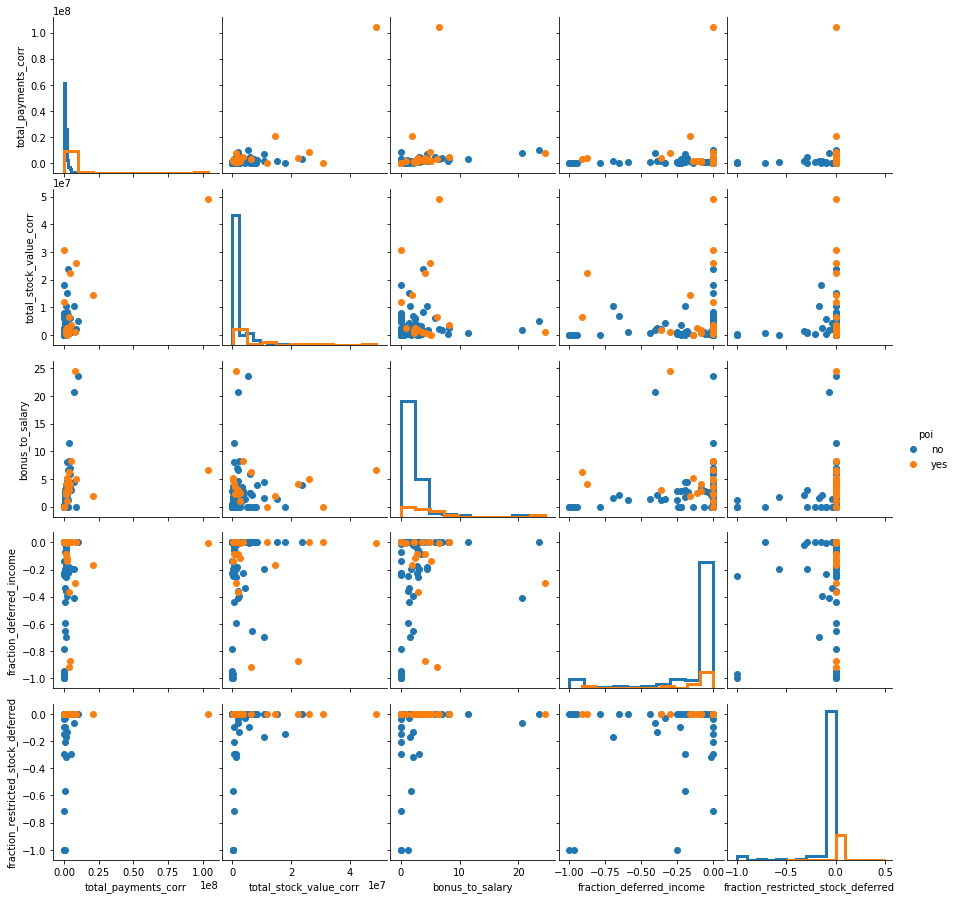

In [6]:
# https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
# https://seaborn.pydata.org/tutorial/axis_grids.html
# df = df_pdf
# df = pd.DataFrame.from_dict(my_dataset, orient='index') #.replace('NaN', np.nan) # Load cleaned dataset

df2plot = deepcopy(df)

df2plot['poi'] = df2plot['poi'].replace(True, 'yes')
df2plot['poi'] = df2plot['poi'].replace(False, 'no')
# features2plot = features_financial_salary+features_financial_stock + features_email + ['poi']
features2plot = features_absolute_cash + features_fractions_lost + ['poi']


df2plot = df2plot[features2plot]
#df2plot = df2plot[~(df2plot.isna().sum(axis=1)>0)] # plot only existing data
#g = sns.pairplot(df2plot, hue="poi") # 

g = sns.PairGrid(df2plot, hue="poi")
#g = sns.PairGrid(df2plot, vars=df2plot.columns[~df2plot.columns.isin(['poi'])].tolist(), hue="poi")
#g = sns.PairGrid(df2plot, vars=df2plot.columns.tolist())
#g = g.map(plt.scatter)
g.fig.subplots_adjust(wspace=.02, hspace=.1);
#g.fig.subplots_adjust(wspace=.02, hspace=.02);
g = g.map_upper(plt.scatter)
g = g.map_diag(plt.hist, histtype="step", linewidth=3)
#g.map_diag(sns.kdeplot, lw=3, legend=False);
#g.map_lower(sns.kdeplot)
g = g.map_lower(plt.scatter)
g.add_legend()
#g.map_offdiag(plt.scatter)


Since the dataset has many features, a relatively small number of records and is additionally pretty sparse, the usual training/testing splitting is not very approproate. Instead, the whole dataset is used for training and cross validation for testing. An appropriate function is `test_classifier()`, which has already been provided by Udacity as part of the module **[tester](tester.py)**.

In [7]:
#df[['poi']+features_fractions_lost].values
#features_list = ['poi']+features_fractions_lost
# features_list = ['poi']+features_fractions_lost+features_absolute_cash
data_d = df.to_dict(orient='index') # Required for Udacitiy's test_classifier
# len(data_d.keys())

## Selection of Classifieres and Exploration of Feature Selection Methods
A set of diverse promising classification methods is selected and applied with the manual and automatic feature selection methods (if applicable). The selected classifiers are:

- **DecisionTreeClassifier**: From the book: "Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are very powerful algorithms, capable of fitting complex datasets."

- **RandomForest**: "Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms available today."

- **NearestCentroid**: is a very simple method that is based on distance calculation (to each class centroid). It might be appropriate for simple problems / few training samples, which is the case in this application. It allows no further tuning as a distribution of data assumed.

- **LogisticRegression**: is a regression algorithm that is appropriately adapted to be used as a classifier:  "Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam? -or that a person is a POI?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier." Furthermore, 

The performance of a classification algorithm depends on the set of provided input features. There are many feature selection functions belonging to a few different concepts. Hence, if applicable, every classifier is combined to each of the (selected) feature selection function. These feature selection functions are investigated and applied:

- **No feature selection**: Simply trying the classifier(s) of choice with all available features of the dataset is probably most straightforward and provides quick results to develop further...

- **Manual feature selection**: Expert knowledge and human intuition will certainly support (or even replace) the automatic feature selection process, especially when the features and can be understood by humans and their number is adequately small, as it is the case for the Enron dataset. The class `DataFrameSelector` is used in a pipeline to filter preselected combinations of promising features.

- **Univariate feature selection**: The class `SelectKBest` can be used with a few different statistical tests to calculate scores and select a specific number of features. The performance of a classifier might depend on the characteristics of a specific (set) of features in combination with the characteristics of the respective classifiers. However, this approach does not consider the nature of the classifier which is applied on a later stage.

- **Recursive Feature Elimination (RFE)**: `RFE` and `SelectFromModel` are feature selection methods, which make use of the `.feature_importances_` or `.coef_` attribute that is provided with some classifiers. Both effectively try to achieve the same result but the methodology used by each technique varies a little: `RFE` removes least significant features over iterations. It first removes a few features which are least important and then fits, removes again, fits and so on. It repeats this iteration until it reaches a predefined number of features. `SelectFromModel` is a little less robust as it just removes less important features based on a threshold given as a parameter, but saves apparently some computation time. `RFE` is selected here, because the dataset is very small but complex.

- **Principal Component Analysis (PCA)**: "is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it." Obviously, the PCA method is also unrelated to another classification method.

Please note that, if applicable, the actual values of the feature importance are not discussed because of usage of an automatic process (RFE)

In [8]:
sss = StratifiedShuffleSplit(n_splits=100, random_state=42) # Applied for ALL models

## Notes on the Analysis and Challenges of the Implementation
- The `Pipeline` class is applied to implement multiple sequential transformations
- `GridSearchCV` is applied with `StratifiedShuffleSplit` to find the best set of parameters of the full Pipeline
- The usage of `StratifiedShuffleSplit` reliably prevents overfitting off a classifer this small dataset.
- `GridSearchCV` is sequentially called in loops with every element of a `param_grid` (while every element defines itself define a parameter grid). The the resulting best classifier of every element is then stored in the list `clf_results`.
- The concept of `RFE` turned out to be very complex to implement when applied with `GridSearchCV` and a pipeline with many steps. As RFE is applied to the selected classifier, the classifier including the actual set of parameters must be provided as a parameter. This breaks the concept of GridSearchCV. I found and tested two methods to apply RFE with a pipeline:
    - Application of the helper function `handle_grid_with_RFE(param_grid)` creates a new modified ParameterGrid to enforce, that RFE gets always provided the same classifier that is applied in the following step of the pipeline.
    - Passing RFE with the whole pipeline as a parameter to GridSearchCV: `GridSearchCV(RFE(**{"estimator":mypipe, **rfe_kwargs}), param_grid=[param_grid_clf], cv=sss, scoring="f1", n_jobs=1)`. Unfortunately, `n_jobs` must be set to 1 due to a bug in joblib or sklearn resulting in extremely poor computation times.
    
## Evaluation Metrics
The most common evaluation metrics are \\(accuracy\\), \\(precision\\), \\(recall\\) and the \\(F_1 \\) score.

### Accuracy
The accuracy is simply the ratio of correctly predicted labels to the total predictions.

\\( accuracy = \frac{TP+TN}{total predictions} \\)

\\(TP\\) and \\(TN\\) are the number of true positives and true negatives. However, accuracy is probably an inappropriate metric especially when the number of records of each class is very imbalanced as it is the case here.

### Precision
Precision is the ratio of correct classifications over all observations with a given predicted label.

\\( precision = \frac{TP}{TP+FP} \\)

Here, it is the ratio of true POI’s over all predicted POI’s.

### Recall
Precision is typically used along with another metric named recall. Its the ratio of positive instances that are correctly detected by the classifier:

\\( recall = \frac{TP}{TP+FN} \\)

FN is the number of false negatives.


### F1 Score
It is often convenient to combine precision and recall into a single metric called the \\(F_1 \\) score, in
particular if you need a simple way to compare two classifiers. The \\(F_1 \\) score is the harmonic mean of
precision and recall.

\\( F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = \frac{TP}{TP + \frac{FN+FP}{2} } \\)

So, the \\(F_1 \\) score favors classifiers that have similar precision and recall. \\(F_1 \\) scoring is selected in `GridSearchCV`.


In [9]:

# https://www.w3cschool.cn/doc_scikit_learn/scikit_learn-modules-pipeline.html
# TODO: First do manual feature selection by thinking.

class myPipe(Pipeline):

    def fit(self, X,y):
        """Calls last elements .coef_ method.
        Based on the sourcecode for decision_function(X).
        Link: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py
        ----------
        """

        super(myPipe, self).fit(X,y)

        self.coef_=self.steps[-1][-1].coef_
        return

pipe_params = [
    #("selector0", None),
    ("scaler0", None),
    ("selector", None),
    #("scaler1", None),
    #("dimreducer", None),
    ("classifier", None)
]

pipe = Pipeline(pipe_params)
mypipe = myPipe(pipe_params)


d_humansel = {
        "selector": [DataFrameSelector()],
        "selector__attribute_names": [
                                  features_absolute_cash+features_fractions_lost,
                                  features_absolute_cash+features_fractions_cash,
                                  features_absolute_cash+features_fractions_lost+features_fractions_cash,
                                  ['total_cash']+features_fractions_lost,
                                  ['total_cash']+['fraction_director_direct_cash']+features_fractions_lost,
                                  features_email+features_absolute_cash+features_fractions_lost,
                                  features_email+features_absolute_cash+features_fractions_cash,
                                  features_email+features_absolute_cash+features_fractions_lost+features_fractions_cash,
                                  features_email+['total_cash']+features_fractions_lost,
                                  features_email+['total_cash']+['fraction_director_direct_cash']+features_fractions_lost                                      
                                 ]
    }
d_RFE = {
        "selector": "RFE"
        #"selector__n_features_to_select": [None, 3,4,5,6,7,8,9,10,11,12,13,14]
}
d_RFE_params = {
        "selector__n_features_to_select": [None, 3,4,5,6,7,8,9,10,11,12,13,14,15,16]
}
d_PCA = {
        "selector": [PCA(random_state=42)],
        "selector__n_components": [None, 0.97, 0.94, 0.9, 0.8] # [None,3,4,5,6,7],
    }

d_PCA_only = {
        "selector": [PCA(random_state=42)],
        "selector__n_components": [None, 3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    }

d_SelectKBest_only = {
        #"dimreducer": [SelectKBest(chi2)],
        "selector": [SelectKBest(f_classif)],
        "selector__k": [3,4,5,6,7,8,9,10,11,12,13,14,15,16]
    }


d_kPCA = { # really computational intensive
        "scaler": [MinMaxScaler()],
        "selector": [KernelPCA(random_state=42)],
        "selector__kernel": ["poly"],#, "linear", "poly", "rbf", "sigmoid"],
        "selector__n_components": [3,2,None] # [None,3,4,5,6,7],
    }
d_scaler0 = {
        "scaler0": [StandardScaler(), MaxAbsScaler()] # RobustScaler(), MaxAbsScaler(), MinMaxScaler()
    }

d_scaler1 = {
        "scaler1": [StandardScaler(), MaxAbsScaler()] #, MinMaxScaler()]
    }

d_dt = {
        "classifier": [DecisionTreeClassifier(random_state=42)],
        "classifier__criterion": ["entropy"],
        "classifier__max_depth": [5,6,7,8,9,10,11, None]
        #"classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    }
d_extratrees = {
        "classifier": [ExtraTreesClassifier(random_state=42)],
        "classifier__criterion": ["entropy"],
        "classifier__n_estimators": [10, 100],
        "classifier__max_depth": [5,6,7,8,9,10,11, None],
        "classifier__bootstrap": [True]
        #"classifier__max_depth": [5,6,7,8,9,10,11, None]
        #"classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    }

d_dt2 = {
        "estimator__classifier": [DecisionTreeClassifier(random_state=42)],
        "estimator__classifier__criterion": ["entropy"],
        "estimator__classifier__max_depth": [9,None] # [5,6,7,8,9,10,11, None]
        #"classifier__max_depth": [5,6,7,8,9,10,11, None]
        #"classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    }
d_logreg = {
        "classifier": [LogisticRegression(random_state=42)],
        "classifier__C": [0.05, 0.5, 1, 1e1, 1e2, 1e3, 1e5, 1e10],
        "classifier__tol":[1e-1, 1e-2, 1e-4, 1e-5, 1e-6, 1e-10],
        "classifier__class_weight":['balanced'],
        "classifier__solver": ["liblinear"]
    }
d_logreg2 = {
        "estimator__classifier": [LogisticRegression(random_state=42)],
        "estimator__classifier__C": [0.05, 0.5, 1, 1e1, 1e2, 1e3, 1e5, 1e10],
        "estimator__classifier__tol":[1e-1, 1e-2, 1e-4, 1e-5, 1e-6, 1e-10],
        "estimator__classifier__class_weight":['balanced'],
        "estimator__classifier__solver": ["liblinear"] #, "newton-cg"]
    }
d_rforest = {
        "classifier": [RandomForestClassifier()],
        "classifier__criterion": ["entropy"],
        "classifier__n_estimators": [10, 50, 100],
        #"classifier__max_features": [None, 4, 5],
        "classifier__max_depth": [3, 4, 5, 6, 7, 8, None]
    }

d_lsvc = {
        "classifier": [LinearSVC(random_state=42)],
        "classifier__C": [0.1, 1.0, 10.0]
}
d_kNeighbors = {
        "classifier": [KNeighborsClassifier()],
        "classifier__weights": ["uniform", "distance"],
        "classifier__n_neighbors": [1,3,5],
        "classifier__p": [1,2]
}
d_kNearestCentroid = {
        "classifier": [NearestCentroid()],
        'classifier__metric': ["euclidean", "manhattan"],
        'classifier__shrink_threshold': [None, 0.1, 1, 10]
}

# RFE müsste gewinnen!
param_grid = [
    #{**d_dt },
    #{**d_scaler0_2, **d_logreg2 } # F1: 
    {**d_scaler0,**d_RFE, **d_logreg }, # F1: 0.53!
    #{**d_scaler1,**d_humansel, **d_logreg }, # F1: 0.5!!!
    #{**d_RFE, **d_rforest },
    #{**d_RFE, **d_PCA, **d_dt }, # Doesn't work because RFE must be applied to complete Pipeline
    #{**d_humansel, **d_dt}, # F1: 0.435
    #{**d_humansel, **d_PCA, **d_logreg},
    #{**d_humansel, **d_PCA, **d_dt}, # F1: 0.462
    #{**d_humansel, **d_kPCA, **d_dt}, # F1: 0.469(poly), 0.4(rbf) Warning: Takes > 10min
    #{**d_humansel, **d_PCA, **d_lsvc}, # F1: 0.39
    #{**d_humansel, **d_PCA, **d_kNearestCentroid}, # F1: 0.45
    #{**d_humansel, **d_scaler, **d_kNearestCentroid}, # 0.41
    #{**d_humansel, **d_PCA, **d_kNeighbors} # F1: 0.4
]


def keep_or_remove_keys(list_of_dicts, keynames=["selector", "classifier"], keep=True):
    "Quick'n dirty"
    if keep:
        for step in list_of_dicts:
            if step is not None:
                step_copy = deepcopy(step)
                for k in step_copy.keys():
                    if not (k.startswith("classifier") or k.startswith("selector")):
                        step.pop(k)
    else: # Not keep -> remove
        for step in list_of_dicts:
            if step is not None:
                step_copy = deepcopy(step)
                for k in step_copy.keys():
                    if k.startswith("classifier") or k.startswith("selector"):
                        step.pop(k)
    return list_of_dicts


def handle_grid_with_RFE(param_grid):
    # First, remove all without keys "classifier" or "selector"
    param_grid_nRFE = deepcopy(param_grid)
    param_grid = keep_or_remove_keys(param_grid)
    param_grid_nRFE = keep_or_remove_keys(param_grid_nRFE, keep=False)

    steps_with_RFE = [] # List with all steps with RFE
    for step in param_grid:
        if step["selector"] == "RFE":
            sel_kwargs_all = {} # All kwargs for the selector
            step_c = deepcopy(step)
            for k_sel in step.keys():
                if k_sel.startswith("selector__"):
                    value = step[k_sel]
                    k_name = k_sel.replace("selector__", "")
                    sel_kwargs_all.update({k_name:value})
                    step_c.pop(k_sel)
            #print("Selector kwargs:{}".format(sel_kwargs_all))
            #print("ParameterGrid:{}".format(list(ParameterGrid(sel_kwargs_all))))
            for sel_kwargs in list(ParameterGrid(sel_kwargs_all)):
                substeps_with_RFE = []
                step_with_RFE = deepcopy(step_c)
                step_with_RFE.pop("selector")
                for s in list(ParameterGrid(step_with_RFE)):
                    new_s = deepcopy(s) # New step!
                    c_base = s["classifier"] # Classifier base class
                    c_class = c_base.__class__
                    c_dict = c_base.__dict__
                    new_kwargs = {} # dict of key word arguments
                    for k in s.keys():
                        if k.startswith("classifier__"):
                            value = s[k]
                            k_name = k.replace("classifier__", "")
                            new_kwargs.update({k_name:value})
                            new_s.pop(k)
                    c_dict.update(new_kwargs)
                    #print("DEBUG HERE")
                    #print(c_class)
                    #print(c_dict)
                    #try:
                    #    d = c_dict["base_estimator"]
                    #    nclf = c_class(d)
                    #    c_dict.pop("base_estimator")
                    #    c_dict.pop("estimator_params")
                    #except:
                    #    print("no base_estimator removed")
                    nclf = c_class(**c_dict)
                    new_s.update({"classifier":[nclf]})
                    # nsel = RFE( **{"estimator":nclf, **sel_kwargs} )
                    nsel = RFE( estimator=nclf )
                    new_s.update({"selector":[nsel]})
                    substeps_with_RFE = substeps_with_RFE + [ new_s ]
                    #print(nc)
                    #print(new_s)
                    #print(substeps_with_RFE)
                steps_with_RFE = steps_with_RFE + substeps_with_RFE
                #param_grid.remove(step) # NACHDENKEN!
        
        # Finally merge back all the non-RFE related steps back to the list
        for step in steps_with_RFE:
            step.update(param_grid_nRFE[0])
    return steps_with_RFE # list of RFE
# pg = list(ParameterGrid(param_grid))
#param_grid
#param_grid = handle_grid_with_RFE(param_grid)
#param_grid[0]

In [10]:
# Store All Scores in the list
clf_results = []

In [ ]:
%%time
#https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns
# WORKS! TODO: Store all results in a Pandas-DataFrame
param_grid_all = [
    #{**d_scaler0, **d_RFE, **d_rforest},
    #{**d_scaler0, **d_RFE, **d_extratrees},
    {**d_scaler0, **d_RFE, **d_dt }, # F1: 0.53!
    {**d_scaler0, **d_RFE, **d_logreg } # F1: 0.53!
]

    #{**d_humansel, **d_PCA, **d_kNearestCentroid}, # F1: 0.45
    #{**d_humansel, **d_scaler, **d_kNearestCentroid}, # 0.41
    #{**d_humansel, **d_PCA, **d_kNeighbors} # F1: 0.4
for param_grid_clf in param_grid_all:
    print(param_grid_clf)
    param_grid = handle_grid_with_RFE([param_grid_clf])
    pg = list(ParameterGrid(d_RFE_params))
    for rfe_kwargs in pg:
        # Add kwargs for RFE
        print("rfe_kwargs:{}".format(rfe_kwargs))
        for step in param_grid:
            for rfe_key in rfe_kwargs.keys():
                step.update({rfe_key: [ rfe_kwargs[rfe_key] ] })

        grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=sss, scoring="f1", n_jobs=-1)

        f = pd.Series(df.columns)
        X_cols = f[~f.isin(['poi'])]
        grid_search.fit(df[X_cols], df['poi'].values)
        #best_clf = grid_search.best_estimator_
        # Store selected feature names
        best_selector = grid_search.best_estimator_.named_steps["selector"]
        # X_cols[best_selector.support_].tolist() # Get the feature names
        clf_results.append( {
                "score": grid_search.best_score_,
                "best_estimator": grid_search.best_estimator_,
                "best_params_": grid_search.best_params_
                #"best_selector": best_selector
            } )

In [ ]:
%%time

# KEEP ME! RFE-Nested Approach. Problems with joblib --> n_jobs=1

# https://www.w3cschool.cn/doc_scikit_learn/scikit_learn-modules-pipeline.html
# TODO: First do manual feature selection by thinking.

class myPipe(Pipeline):
    def fit(self, X,y):
        """Calls last elements .coef_ method.
        Based on the sourcecode for decision_function(X).
        Link: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/pipeline.py
        ----------
        """
        super(myPipe, self).fit(X,y)
        #self.coef_=self.steps[-1][-1].coef_
        self.coef_=self.steps[-1][-1].feature_importances_
        return

pipe_params = [
    ("scaler0", None),
    ("selector", None),
    ("classifier", None)
]
d_scaler0_2 = {
        "estimator__scaler0": [StandardScaler(), MaxAbsScaler()] #, MinMaxScaler()]
    }
d_dt2 = {
        "estimator__classifier": [DecisionTreeClassifier(random_state=42)],
        "estimator__classifier__criterion": ["entropy"],
        "estimator__classifier__max_depth": [9,None] # [5,6,7,8,9,10,11, None]
        #"classifier__max_depth": [5,6,7,8,9,10,11, None]
        #"classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    }

d_logreg2 = {
        "estimator__classifier": [LogisticRegression(random_state=42)],
        "estimator__classifier__C": [0.05, 0.5, 1, 1e1, 1e2, 1e3, 1e5, 1e10],
        "estimator__classifier__tol":[1e-1, 1e-2, 1e-4, 1e-5, 1e-6, 1e-10],
        "estimator__classifier__class_weight":['balanced'],
        "estimator__classifier__solver": ["liblinear"] #, "newton-cg"]
    }
d_rforest_2 = {
        "estimator__classifier": [RandomForestClassifier()],
        "estimator__classifier__criterion": ["entropy"],
        "estimator__classifier__n_estimators": [10, 50, 100],
        #"classifier__max_features": [None, 4, 5],
        "estimator__classifier__max_depth": [3, 4, 5, 6, 7, 8, None]
    }
d_RFE_params_2 = {
        "n_features_to_select": [None, 3,4,5,6,7,8,9,10,11,12,13,14,15,16]
}

pipe = Pipeline(pipe_params)
mypipe = myPipe(pipe_params)

param_grid_all = [
    #{**d_scaler0_2, **d_dt2},
    {**d_scaler0_2, **d_rforest_2},
    #{**d_scaler0, **d_RFE, **d_extratrees},
]


for param_grid_clf in param_grid_all:
    print(param_grid_clf)
    #param_grid = handle_grid_with_RFE([param_grid_clf])
    pg = list(ParameterGrid(d_RFE_params_2))
    for rfe_kwargs in pg:
        # Add kwargs for RFE
        print("rfe_kwargs:{}".format(rfe_kwargs))

        selector = RFE(**{"estimator":mypipe, **rfe_kwargs})
        grid_search = GridSearchCV(selector, param_grid=[param_grid_clf], cv=sss, scoring="f1", n_jobs=1)

        f = pd.Series(df.columns)
        grid_search.fit(df[f[~f.isin(['poi'])]], df['poi'].values)
        clf_results.append( {
            "score": grid_search.best_score_,
            "best_estimator": grid_search.best_estimator_,
            "best_params_": grid_search.best_params_
        } )

In [ ]:
# Human selector: Apply DataFrameSelector

%%time

pipe_params = [
    #("selector0", None),
    ("selector", None),
    ("scaler0", None),
    #("dimreducer", None),
    ("classifier", None)
]

pipe = Pipeline(pipe_params)


# Neue Pipeline mit DataFrameSelector am Anfang machen
param_grid_all = [
    {**d_dt }, # F1: 0.53!
    {**d_humansel, **d_dt }, # F1: 0.53!
    {**d_scaler0, **d_humansel, **d_dt }, # F1: 0.53!
    #{**d_scaler0, **d_PCA_only, **d_dt }, # WORKS

    {**d_logreg },
    {**d_scaler0, **d_logreg}, # WORKS
    {**d_scaler0, **d_humansel, **d_logreg}, # WORKS
    #{**d_scaler0, **d_PCA_only, **d_logreg },

    {**d_kNearestCentroid}, # F1: WORKS
    {**d_scaler0, **d_kNearestCentroid}, # F1: WORKS
    {**d_scaler0, **d_humansel, **d_kNearestCentroid}, # F1: WORKS
    #{**d_scaler0, **d_PCA_only, **d_kNearestCentroid}, # F1: 0.47
    
    {**d_rforest},
    {**d_scaler0, **d_rforest},
    {**d_scaler0, **d_humansel, **d_rforest}
    #{**d_scaler0, **d_PCA_only, **d_rforest }, # WORKS
]


for param_grid_clf in param_grid_all:
    pg=[param_grid_clf]
    print(pg)
    grid_search = GridSearchCV(pipe, param_grid=pg, cv=sss, scoring="f1", n_jobs=-1)

    f = pd.Series(df.columns)
    X_cols = f[~f.isin(['poi'])]
    grid_search.fit(df[X_cols], df['poi'].values)
    clf_results.append( {
            "score": grid_search.best_score_,
            "best_estimator": grid_search.best_estimator_,
            "best_params_": grid_search.best_params_
        } )
        #break

In [ ]:
%%time
# PCA and SelectLBest
pipe_params = [
    #("selector", None),
    ("scaler0", None),
    ("selector", None),
    ("classifier", None)
]

pipe = Pipeline(pipe_params)


param_grid_all = [
    {**d_scaler0, **d_PCA_only, **d_kNearestCentroid}, # F1: 0.47
    {**d_scaler0, **d_PCA_only, **d_logreg }, # F1: 0.53!
    {**d_scaler0, **d_PCA_only, **d_dt }, # WORKS
    {**d_scaler0, **d_PCA_only, **d_rforest }, # WORKS
    {**d_scaler0, **d_SelectKBest_only, **d_dt }, # F1: 0.53!
    {**d_scaler0, **d_SelectKBest_only, **d_logreg }, # F1: 0.53!
    {**d_scaler0, **d_SelectKBest_only, **d_kNearestCentroid}, # F1: 0.47
    {**d_scaler0, **d_SelectKBest_only, **d_rforest},
]

for param_grid_clf in param_grid_all:
    pg=[param_grid_clf]
    print(pg)
    grid_search = GridSearchCV(pipe, param_grid=pg, cv=sss, scoring="f1", n_jobs=-1)

    f = pd.Series(df.columns)
    X_cols = f[~f.isin(['poi'])]
    grid_search.fit(df[X_cols], df['poi'].values)
    clf_results.append( {
            "score": grid_search.best_score_,
            "best_estimator": grid_search.best_estimator_,
            "best_params_": grid_search.best_params_
        } )
        #break

In [511]:
some_list = ["aldk", "def", "abc", "asd"]
if any("abc" == s for s in some_list):
    print("yes")

yes


In [534]:
def clf_extract_stats(clf_list):
    """Function to extract some results from the list of (best) classifiers"""
    f = pd.Series(df.columns)
    X_cols = f[~f.isin(['poi'])]
    # X_cols[best_selector.support_].tolist() # Get the feature names
    new_list = []
    for clf in clf_list:
        c = clf["best_params_"]
        e = clf["best_estimator"]
        cn = {}
        for ckey in clf.keys(): # Add scores to result if available
            if any(ckey == s for s in ["accuracy","precision","recall","f1","f2"]):
                cn[ckey] = clf[ckey]
        cn["score"] = clf["score"]
        for k in c.keys():
            #print(k)
            n = c[k].__class__.__name__ # :-D
            cn[k] = n
        try:
            cn["selector"]
            if cn["selector"] == "SelectKBest":
                cn["features"] = X_cols[ c["selector"].get_support() ].tolist() # Get the feature names
                cn["n_features"] = len(cn["features"])
            if cn["selector"] == "RFE":
                cn["features"] = X_cols[ c["selector"].support_ ].tolist() # Get the feature names
                cn["n_features"] = c["selector"].n_features_ #len(cn["features"])
            if cn["selector"] == "DataFrameSelector":
                cn["features"] = c["selector__attribute_names"]
                cn["n_features"] = len(cn["features"])
            if cn["selector"] == "PCA":
                #print("PCA!!!!!!!!!!!!!")
                cn["n_features"] = c["selector__n_components"]
                #print("PCAn:{}".format(cn["n_features"]))
            try:
                cn["selector__n_features_to_select"]
                cn["selector__n_features_to_select"] = c["selector__n_features_to_select"]
            except KeyError:
                pass
                #print("KE")
        except KeyError:
            pass
            #print("KeyError: No selector")
        try:
            cn["estimator__classifier"]
            cn["classifier"] = c["estimator__classifier"].__class__.__name__
            cn["selector"] = "RFE"
            cn["n_features"] = e.n_features_
            cn["features"] = X_cols[ e.support_ ].tolist()
        except:
            pass
            #print("KeyError: No RFE withe nested estimator")
        new_list.append(cn)
        #print(cn)
    return new_list

df_results = pd.DataFrame.from_dict(clf_results)
clf_results_h = clf_extract_stats(clf_results)
df_results_h = pd.DataFrame.from_dict(clf_results_h)
#HTML(df_results_h.to_html())
#clf_results[34]["best_params_"]["selector__attribute_names"]

In [429]:
#df_results["best_estimator"].iloc[41].n_features_

In [431]:
clf_results_h = clf_extract_stats(clf_results)
df_results_h = pd.DataFrame.from_dict(clf_results_h)
df_results_h["selector"] = df_results_h["selector"].fillna("No selector")
df_results_h.sort_values(["classifier", "selector"])
#df_results_h["dimreducer"] = df_results_h["dimreducer"].fillna("No reducer")
df_results_h_grp = df_results_h.groupby(["classifier", "selector"])
df_result = pd.DataFrame() #(columns=["scaler0", "selector", "n_features", "features", "classifier"])
for grp, result in df_results_h_grp:
    #print(grp)
    posmax = result["score"].idxmax()
    #print(posmax)
    df_row = result[["score", "scaler0", "selector", "n_features", "features", "classifier"]].loc[posmax]
    #print(df_row)
    df_result = df_result.append(df_row, ignore_index=True)
#HTML(df_result.to_html())

## Selecting the Best Classifier and Pipeline

The following figure compares all combinations of every best classifier with a feature selection function.

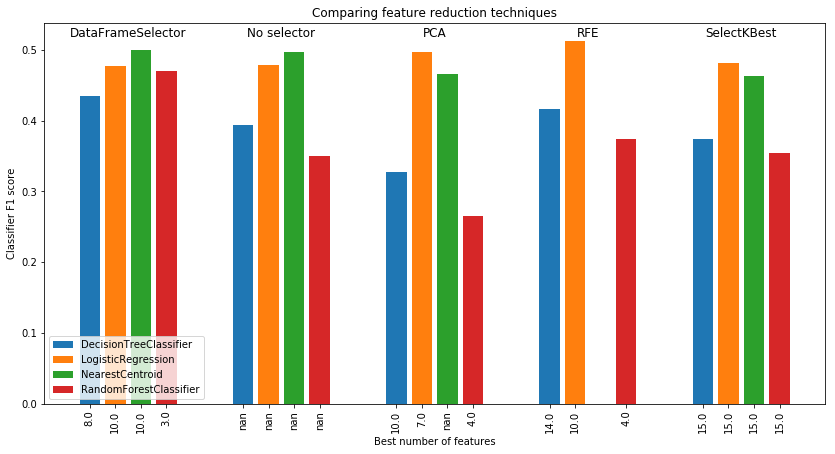

In [118]:
plt.figure(figsize=(14,7))
COLORS = 'bgrcmyk'
alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}

df_result_grp = df_result.groupby(["classifier"])
nlabels = 5
ngroups = 5 #len(df_result_grp)
bar_offsets = pd.Series(index=np.sort(df_result["selector"].unique()), data=np.arange(ngroups) * (nlabels + 1) + .5)
xticks = []
xlabels = []
for i, (cname, elements) in enumerate(df_result_grp):
    X = bar_offsets[elements["selector"]] + i
    plt.bar(X, elements["score"], label=cname)
    xticks.append(list(X))
    xlabels.append(list(elements["n_features"])) # + ", " + str(elements["features"]) ))

l = zip(bar_offsets.index,bar_offsets.values)
for name, x in l:
    plt.text(x+1.5, 0.518, name, size='large', **alignment)
plt.title("Comparing feature reduction techniques")
plt.xlabel('Best number of features')

xpos = [item for sublist in xticks for item in sublist]
xlab = [item for sublist in xlabels for item in sublist]
plt.xticks(xpos, xlab, rotation=90)

plt.ylabel('Classifier F1 score')
#plt.ylim((0, 1))
plt.legend(loc='lower left')

plt.show()

- The best scoring classifier is the LogisticRegression with RFE.
- Number 2 is `NearestCentroid`, showing a robust performance with all feature selection functions.
- The pre-selected feature combinations with the DataFrameSelector shows the "most solid" performance with all classifiers.
- RFE performs surprisingly bad with `DecisionTreeClassifier` and `RandomForest`. A possible explanation is given in this blog post: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
- However, the `DecisionTreeClassifier` and `RandomForest` constitute very simple classifiers with just a few features.
- Note that the magnitudes may change a bit when the number of folds is increased from 100 to 1000.

The complete list of the best pipelines with the selected features is shown in the following table. "NaN" inidcates that all features are applied.

In [438]:
old_width = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
#open('some_file.html', 'w').write(some_data.to_html())
#display(HTML(df_result[["score","classifier","selector","n_features", "features"]].sort_values(["score"], ascending=False).head(10).to_html()))
display(HTML(df_result[
        ["score","classifier","selector","n_features", "features"]
    ].sort_values(["score"], ascending=False).reset_index().drop("index",axis=1).to_html()))
pd.set_option('display.max_colwidth', old_width)

,score,classifier,selector,n_features,features
0,0.512508,LogisticRegression,RFE,10.0,"[total_stock_value, expenses, from_messages, total_stock_value_corr, total_cash, bonus_to_salary, fraction_exercised_stock_options, fraction_restricted_stock_deferred, fraction_employer_stock_cash, fraction_from_this_person_to_poi]"
1,0.499619,NearestCentroid,DataFrameSelector,10.0,"[to_messages, from_messages, fraction_from_poi_to_this_person, fraction_shared_receipt_with_poi, fraction_from_this_person_to_poi, total_payments_corr, total_stock_value_corr, bonus_to_salary, fraction_deferred_income, fraction_restricted_stock_deferred]"
2,0.497714,NearestCentroid,No selector,NaN,NaN
3,0.497343,LogisticRegression,PCA,7.0,NaN
4,0.481589,LogisticRegression,SelectKBest,15.0,"[total_payments, loan_advances, total_stock_value, expenses, other, total_payments_corr, total_stock_value_corr, total_cash, bonus_to_salary, fraction_salary, fraction_bonus, fraction_employer_stock_cash, fraction_from_poi_to_this_person, fraction_shared_receipt_with_poi, fraction_from_this_person_to_poi]"
5,0.478422,LogisticRegression,No selector,NaN,NaN
6,0.477180,LogisticRegression,DataFrameSelector,10.0,"[to_messages, from_messages, fraction_from_poi_to_this_person, fraction_shared_receipt_with_poi, fraction_from_this_person_to_poi, total_payments_corr, total_stock_value_corr, bonus_to_salary, fraction_deferred_income, fraction_restricted_stock_deferred]"
7,0.469714,RandomForestClassifier,DataFrameSelector,3.0,"[total_cash, fraction_deferred_income, fraction_restricted_stock_deferred]"
8,0.466279,NearestCentroid,PCA,NaN,NaN
9,0.463567,NearestCentroid,SelectKBest,15.0,"[total_payments, loan_advances, total_stock_value, expenses, other, total_payments_corr, total_stock_value_corr, total_cash, bonus_to_salary, fraction_salary, fraction_bonus, fraction_employer_stock_cash, fraction_from_poi_to_this_person, fraction_shared_receipt_with_poi, fraction_from_this_person_to_poi]"


It is worth to point out, that the best performing RandomForest uses three features only, namely [total_cash, fraction_deferred_income, fraction_restricted_stock_deferred], making use of the very common human perception that "high performers" with insider knowledge are likely evil criminals at the same time.

In [175]:
c = df_result["classifier"]=="RandomForestClassifier"
best_score_rf = df_result["score"][c].max()
best_rf_features = df_result.loc[df_result["score"][c].idxmax(), "features"]
best_rf = df_results.loc[ df_results["score"]==best_score_rf, "best_estimator"].values[0]

In [434]:
#best_rf.named_steps["selector"]

## Comparing The Best Results Using the Tester

The pipeline with the best classifiers of each class is calculated again using the best scoring set of features and a more fine grained parameter grid. The reliability of the metrics and scores is increased through increase of n_splits to 1000.
Finally, the optimization of the `LogisticRegression` is implemented in `poi_id.py` to generate the result files.

In [620]:
# Use best class of features
sss_final = StratifiedShuffleSplit(n_splits=1000, random_state=42) # Applied for ALL models

d_bestsel = {
        "selector": [DataFrameSelector()],
        "selector__attribute_names": [
                                  ["total_cash", "fraction_deferred_income", "fraction_restricted_stock_deferred"],
                                  ["total_stock_value", "expenses", "from_messages", "total_stock_value_corr", "total_cash",
                                  "bonus_to_salary", "fraction_exercised_stock_options", "fraction_restricted_stock_deferred",
                                  "fraction_employer_stock_cash", "fraction_from_this_person_to_poi"]
                                 ]
    }
d_logreg = {
        "classifier": [LogisticRegression(random_state=42)],
        "classifier__C": [0.02, 0.03, 0.04, 0.05, 0.5, 1, 1e1, 1e2, 1e3, 1e5, 1e10],
        "classifier__tol":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-10],
        "classifier__class_weight":['balanced'],
        "classifier__solver": ["liblinear"]
    }
d_dt_fine = {
        "classifier": [DecisionTreeClassifier(random_state=42)],
        "classifier__criterion": ["entropy"],
        "classifier__max_depth": [5,6,7,8,9,10,11, None],
        "classifier__min_samples_leaf": [1,2,3,4,5] # Makes it worse
    }

d_PCA_2 = {
        "dimreducer": [PCA(random_state=42)],
        "dimreducer__n_components": [None, 0.97, 0.94, 0.9, 0.8] # [None,3,4,5,6,7],
    }
clf_best_results = []  # The best classifiers are stored in a list.

In [621]:
%%time

pipe_params = [
    #("selector0", None),
    ("selector", None),
    ("scaler0", None),
    #("dimreducer", None),
    ("classifier", None)
]

pipe = Pipeline(pipe_params)


# Neue Pipeline mit DataFrameSelector am Anfang machen
param_grid_all = [
    {**d_bestsel, **d_dt_fine }, # Accuracy: 0.87207	Precision: 0.52920	Recall: 0.36700	F1: 0.43342	F2: 0.39097
    ##{**d_scaler0, **d_bestsel, **d_PCA_2, **d_dt_fine }, # Accuracy: 0.87207	Precision: 0.52920	Recall: 0.36700	F1: 0.43342	F2: 0.39097
    {**d_scaler0, **d_bestsel, **d_logreg}, # Accuracy: 0.77980	Precision: 0.36862	Recall: 0.91400	F1: 0.52536	F2: 0.70530

    
    ##{**d_scaler0, **d_kNearestCentroid}, # Most simple one!
    {**d_scaler0, **d_bestsel, **d_kNearestCentroid}, # F1: WORKS
    
    {**d_scaler0, **d_bestsel, **d_rforest} # Remove to make it work!
    ##{**d_bestsel, **d_rforest} # Remove to make it work!
]


for param_grid_clf in param_grid_all:
    pg=[param_grid_clf]
    #print(pg)
    grid_search = GridSearchCV(pipe, param_grid=pg, cv=sss, scoring="f1", n_jobs=-1)

    f = pd.Series(df.columns)
    X_cols = f[~f.isin(['poi'])]
    grid_search.fit(df[X_cols], df['poi'].values)
    clf_best_results.append( {
            "score": grid_search.best_score_,
            "best_estimator": grid_search.best_estimator_,
            "best_params_": grid_search.best_params_
        } )

CPU times: user 2min 32s, sys: 1.49 s, total: 2min 34s
Wall time: 3min


In [622]:
#%%time
score_list = [c["score"] for c in clf_best_results]
best_params = clf_best_results[np.argmax(score_list)]["best_params_"]

pipe_final_params = [
    ("scaler0", best_params["scaler0"]),
    #("dimreducer", best_estimator.named_steps["dimreducer"]),
    ("classifier", best_params["classifier"])
]

pipe_final = Pipeline(pipe_final_params)
features_final = best_params["selector__attribute_names"]
#features_final
#X_cols.tolist()#, df['poi'].values

The Pipeline and the selected features of the best classifier are extracted from the list of best results, in order to call Udacity's `test_classifier` in the next step.

In [629]:
#print("Best F1 score:{}".format(max(score_list)))

In [630]:
pipe_final

Pipeline(memory=None,
     steps=[('scaler0', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=0.04, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False))])

In [631]:
print(features_final)

['total_stock_value', 'expenses', 'from_messages', 'total_stock_value_corr', 'total_cash', 'bonus_to_salary', 'fraction_exercised_stock_options', 'fraction_restricted_stock_deferred', 'fraction_employer_stock_cash', 'fraction_from_this_person_to_poi']


`test_classifier` is called here to provide the result for reference. Please note that the results might be slightly different, when a different versions of the Sklearn is used.

In [632]:
%%time
from tester import test_classifier
# grid_search.fit(df[X_cols], df['poi'].values)
test_classifier(pipe_final, data_d, ['poi']+features_final, folds=1000)

Pipeline(memory=None,
     steps=[('scaler0', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=0.04, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.01, verbose=0, warm_start=False))])
	Accuracy: 0.77273	Precision: 0.36286	Recall: 0.93200	F1: 0.52235	F2: 0.70945
	Total predictions: 15000	True positives: 1864	False positives: 3273	False negatives:  136	True negatives: 9727

CPU times: user 1.92 s, sys: 3.99 ms, total: 1.92 s
Wall time: 1.92 s


The tester function `test_classifier2` is a modified variant of `test_classifier` in order to compare all metrics of all classifiers. It is called in a loop with the best pipeline of each classifier type to compare all their scores.

In [652]:
def test_classifier2(clf, dataset, feature_list, folds = 1000):
    """Returns the result scores"""
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    # cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    cv = StratifiedShuffleSplit(n_splits=folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    # for train_idx, test_idx in cv:
    for train_idx, test_idx in cv.split(features, labels):
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )

        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print("Warning: Found a predicted label not == 0 or 1.")
                print("All predictions should take value 0 or 1.")
                print("Evaluating performance for processed predictions:")
                break
    result_dict = {}
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)

        result_dict = {
            "clf": clf,
            "accuracy":  accuracy,
            "precision": precision,
            "recall":    recall,
            "f1":        f1,
            "f2":        f2
        }
    except:
        print("Got a divide by zero when trying out:", clf)
        print("Precision or recall may be undefined due to a lack of true positive predicitons.")
    return result_dict

In [654]:
%%time
# Run test_classifier in a loop to get all the scores
#from tester import test_classifier2
clf_best_results_scores = []
for c in clf_best_results:
    best_params = c["best_params_"]
    try:
        s0 = best_params["scaler0"]
    except KeyError:
        s0 = None
    pipe_final_params = [
        ("scaler0", s0),
        #("dimreducer", best_estimator.named_steps["dimreducer"]),
        ("classifier", best_params["classifier"])
    ]
    pipe_final = Pipeline(pipe_final_params)
    #print(pipe_final)
    features_final = best_params["selector__attribute_names"]
    scores = test_classifier2(pipe_final, data_d, ['poi']+features_final, folds=1000)
    clf_best_results_scores.append({**c, **scores})

CPU times: user 46.8 s, sys: 3.88 ms, total: 46.8 s
Wall time: 46.8 s


In [660]:
# Plot decision tree
dt_id = 0
#pipe_dt_params = [("classifier", clf_best_results_scores[dt_id]["best_params_"]["classifier"])]
#pipe_dt = Pipeline(pipe_final_params)
pipe_dt =clf_best_results_scores[dt_id]["clf"].named_steps["classifier"]
features_final = clf_best_results_scores[dt_id]["best_params_"]["selector__attribute_names"]
#pipe_dt_fit = pipe_dt.fit(df[X_cols], df['poi'].values)

In [664]:
from sklearn.tree import export_graphviz
export_graphviz(
    pipe_dt,
    out_file="files/DecisionTreeClassifier.dot",
    feature_names=features_final, #features_list[1:],
    class_names=["no", "yes"],
    rounded=True,
    filled=True
)

In [665]:
%%bash
dot -Tpng files/test_tree.dot -o files/DecisionTreeClassifier.png

The behaviour of a `DecisionTreeClassifier` can be illustrated regardless of the number of features and can be understood by humans: This is an evil "money tree" as only financial features are present.

In [666]:
import random
__counter__ = random.randint(0,2e9)
display(HTML('<img src="files/DecisionTreeClassifier.png?%d" alt="Decision tree" height="100">' % __counter__))

Finally, the scores of the best rated classifiers are compared in the following figure.

In [667]:
clf_best_results_h = clf_extract_stats(clf_best_results_scores)
df_best_results_h = pd.DataFrame.from_dict(clf_best_results_h)

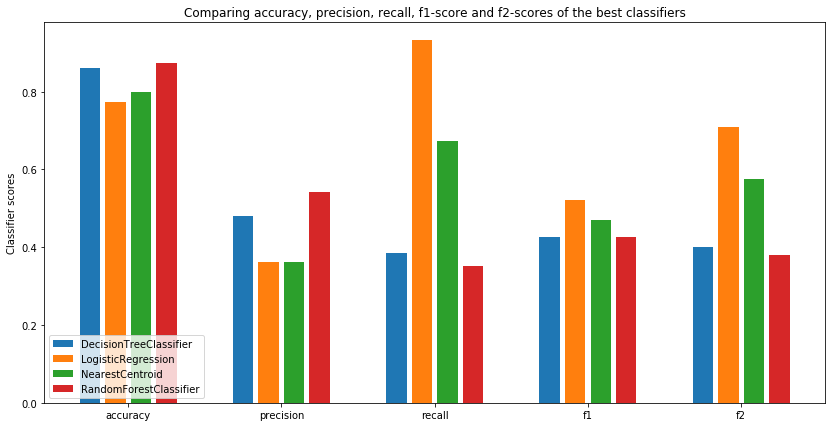

In [668]:
plt.figure(figsize=(14,7))
COLORS = 'bgrcmyk'
alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}

df_result_grp = df_best_results_h.groupby(["classifier"])
nlabels = 5
ngroups = 5 #len(df_result_grp)
score_list = ["accuracy", "precision", "recall", "f1", "f2"]
bar_offsets = pd.Series(index=score_list, data=np.arange(ngroups) * (nlabels + 1) + .5)
xticks = []
xlabels = []
for i, (cname, elements) in enumerate(df_result_grp):
    X = bar_offsets[score_list] + i
    #print(X)
    #print(type(X))
    #print(elements[score_list].squeeze())
    #print(type(elements[score_list]))
    plt.bar(X, elements[score_list].squeeze(), label=cname)
    xticks.append(list(X))
    xlabels.append(list(elements["n_features"])) # + ", " + str(elements["features"]) ))

l = zip(bar_offsets.index,bar_offsets.values)
#for name, x in l:
#    plt.text(x+1.5, 0.518, name, size='large', **alignment)
plt.title("Comparing accuracy, precision, recall, f1-score and f2-scores of the best classifiers")
#plt.xlabel('Best number of features')

xpos = [item for sublist in xticks for item in sublist]
#xlab = [item for sublist in xlabels for item in sublist]
#plt.xticks(xpos, '') #, xlab, rotation=90)
plt.xticks(bar_offsets+1.5, score_list) #, xlab, rotation=90)

plt.ylabel('Classifier scores')
#plt.ylim((0, 1))
plt.legend(loc='lower left')

plt.show()

# Conclusions
- A classifier has been implemented to find a POI using financial "insider payments" data and e-mail metadata.
- `LogisticRegression` achieves the best \\(F_1\\)-score and an excellent \\(recall\\).
- A better recall is certainly more important for this application than precision: Having a few false alerts is probably is prbably ok when almost all POI's get caught in the end. The misclassified innocents will be (hopefully) declared innocent after appropriate police investigation.


# References
1. Book: "Hands-On Machine Learning with Scikit-Learn & TensorFlow"
2. Scikit-Learn documentation: [Model evaluation: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html)
3. Scikit-Learn documentation: [Pipelines and composite estimators](https://scikit-learn.org/stable/modules/compose.html)
4. [From Pandas to Scikit-Learn — A new exciting workflow](https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62)
5. Blog post: [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
6. From datascience.stackexchange: [Will cross validation performance be an accurate indication for predicting the true performance on an independent data set?](https://datascience.stackexchange.com/questions/17755/will-cross-validation-performance-be-an-accurate-indication-for-predicting-the-t/17835#17835)
7. sklearn-evaluation package documentation [Evaluating Grid Search Results](https://blancas.io/sklearn-evaluation/user_guide/grid_search.html)
8. Scikit-learn documentation: [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers)
9. [How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c)
10. Scikit-learn documentation: [Advanced installation instructions](http://scikit-learn.org/dev/developers/advanced_installation.html#install-bleeding-edge)
11. [Installing python packages in development mode](https://avolkov.github.io/installing-python-packages-in-development-mode.html)